In [6]:
import os
import glob
#import nibabel as nib
import numpy as np
import cv2
# import math
import torch
import scipy

import matplotlib.pyplot as plt
import plotly.express as px
import csv
import re
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

In [3]:
from src.model.segmentation import Unet
from src.model.correction import CorrectionUnet, MultiModalCorrectionUnet, MultiModal3BlockCorrectionUnet
from src.data.correction_generator import CorrectionDataLoader, CorrectionMRIDataset, CorrectionMRIDatasetSequences
from src.data.data_generator import MRIDataset
# from src.utils import EarlyStopper, make_output_dirs, preview_cuts, record_used_files, save_history
from src.losses.dice import dice_coefficient, DiceLoss
from src.losses.correction import CorrectionLoss

In [4]:
import torch
import cv2
import scipy
import numpy as np
from src.data.utils import _select_points

def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    glioma_indices = torch.nonzero((mask > 0))[:, 1]
    if len(glioma_indices) == 0:
        return 0, 0

    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last

def get_border(mask: torch.Tensor):
    mask = mask.numpy()
    erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(3, 3))
    eroded_seg = cv2.erode(mask, kernel=erosion_kernel)
    border = mask - eroded_seg
    
    return border

def get_potential_coords(y_coords: list, diff_coords: list):
    # get coords (potential clicks), 
    # that are also in the original seg
    potential_clicks = []
    for coord in y_coords:
        if coord in diff_coords:
            potential_clicks.append(coord)
    
    return potential_clicks

def get_clicks(mask: torch.Tensor, pred: torch.Tensor, clicks_num=2, clicks_dst=4, seed=None) -> torch.Tensor:
    border = get_border(mask)
    
    if len(mask[mask == 1]) > len(pred[pred == 1]):
        dst = scipy.ndimage.distance_transform_edt(1 - pred)
    else:
        dst = scipy.ndimage.distance_transform_edt(pred)
        # dst = 1 - dst
        # dst[dst == 1] = 0
        # dst[dst != 0] -= np.min(dst)
    weighted_border = dst * border 
    
    if weighted_border.max() == 0.0:
        return torch.zeros_like(mask)

    # maybe find pixels in certain threshold
    indicies = np.where(weighted_border == weighted_border.max())
    clicks_coords = list(zip(*indicies))
    
    # select_clicks
    selected_points = _select_points(np.array(clicks_coords), clicks_num, clicks_dst)
    clicks = np.zeros_like(mask)
    for c in selected_points:
        clicks[c[0], c[1]] = 1

    return torch.as_tensor(clicks)

def simulate_clicks(mask: torch.Tensor, pred: torch.Tensor, clicks_num=2, clicks_dst=4, seed=None) -> torch.Tensor:
    clicks = torch.zeros_like(mask)
    start, end = get_glioma_indices(pred)
    for slice_idx in range(start, end+1):
        clicks[0,slice_idx] = get_clicks(mask[0,slice_idx], pred[0,slice_idx], clicks_num, clicks_dst, seed)
    return clicks

def cut_volume(seg: torch.Tensor, cut_size=32, num: int = np.inf) -> list[torch.Tensor]:
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(seg[1])

    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        # Cut the volume based on the specified cut size
        cut = torch.clone(seg[0][coords[0]])
        cut = cut[
            coords[1] - cut_size : coords[1] + cut_size,
            coords[2] - cut_size : coords[2] + cut_size,
        ].unsqueeze(0)

        # print(cut.shape, coords)
        
        cuts.append(cut)

    return cuts

def generate_cuts(seg, seq, clicks, cut_size):
    seg_cuts = cut_volume(torch.stack((seg, clicks)), cut_size=cut_size)
    t1_cuts = cut_volume(torch.stack((seq[0], clicks)), cut_size=cut_size)
    t2_cuts = cut_volume(torch.stack((seq[1], clicks)), cut_size=cut_size)

    return seg_cuts, t1_cuts, t2_cuts

#### Utility

In [16]:
def plot_tumour(mask: torch.Tensor):
    """Plot individual slices of the tumour in one figure."""
    
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(mask)
    print("Tumour indices: ", first, last)

    length = last - first + 1
    n_graphs = (length) // 4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0
    for i in range(first, last):
        if j >= len(axs):
            break
        axs[j].imshow(mask[0, i, :, :], cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(f"mask slice {i}", fontsize=9)
        j += 1

    plt.show()

def plot_cuts(cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
        tmp_cut = torch.clone(cut)
        if plot_click:
            tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

def plot_cut(cut, cmap='magma'):
    tmp_cut = torch.clone(cut)
    tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
    plt.imshow(tmp_cut, cmap=cmap)

def plot_cuts_with_seq(cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = 4
    cols = 3
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        
        # if len(cut.shape) == 3:
        #     cut = cut.squeeze(0)
        
        tmp_cut = torch.clone(cut[0])
        if plot_click:
            tmp_cut[cut[0].shape[0]//2, cut[0].shape[0]//2] = 2
        axs[j].imshow(cut[1], cmap='gray')
        axs[j].axis('off')
        axs[j].set_title(f't1 cut {i}', fontsize=9)
        axs[j+1].imshow(cut[2], cmap='gray')
        axs[j+1].axis('off')
        axs[j+1].set_title(f't2 cut {i}', fontsize=9)
        axs[j+2].imshow(tmp_cut, cmap=cmap)
        axs[j+2].axis('off')
        axs[j+2].set_title(f'seg cut {i}', fontsize=9)
        j += 3

    plt.show()   

def plot_cuts_with_true(cuts: list[torch.Tensor], true_cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0

    colormap = {
        'bg': 'black',
        'pred': 'purple',
        'true': 'red',
        'overlap': 'orange',
        'click': 'yellow'
    }
    cmap = ListedColormap([colormap['bg'], colormap['pred'], colormap['true'], colormap['overlap'], colormap['click']])
    
    for i, (cut, true_cut) in enumerate(zip(cuts, true_cuts)):
        if j >= len(axs): 
            break
        
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
            true_cut = true_cut.squeeze(0)
        
        tmp_cut = torch.clone(cut)
        tmp_true_cut = torch.clone(true_cut)
        tmp_true_cut[tmp_true_cut == 1] = 2
        
        if plot_click:
            tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        
        axs[j].imshow(tmp_cut + tmp_true_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

def get_unused_data(model_path, data_path):
    # Load used training files from csv
    d = os.path.join(model_path, "training_files.csv")
    pd.read_csv(os.path.join(model_path, "training_files.csv"))

    used_files = []
    with open(d) as file:
        training_files = csv.reader(file)
        used_files = [f for f in training_files]
    used_files.pop(0)

    # modify the loaded paths to match the local fs
    # pattern = r"VS-\d+-\d+/vs_\w+/\w+\w+\.nii\.gz"
    used_t1 = []
    used_t2 = []
    used_seg = []

    for paths in used_files:
        used_t1.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_t1_\w+\.nii\.gz", paths[0]).group()))
        used_t2.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_t2_\w+\.nii\.gz", paths[1]).group()))
        used_seg.append(os.path.join(data_path, re.search(r"VS-\d+-\d+/vs_\w+/\w+_seg_\w+\.nii\.gz", paths[2]).group()))

    print(len(used_t1), len(used_t2), len(used_seg))
    print(used_t1[:3])
    print(used_t2[:3])
    print(used_seg[:3])

    # os.listdir(data_path)
    t1_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_t1_*")))
    t2_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_t2_*")))
    seg_list = sorted(glob.glob(os.path.join(data_path, "VS-*-*/vs_*/*_seg_*")))
    print(t1_list[:2])

    unused_t1 = sorted(list(set(t1_list) - set(used_t1)))
    unused_t2 = sorted(list(set(t2_list) - set(used_t2)))
    unused_seg = sorted(list(set(seg_list) - set(used_seg)))

    print(len(unused_t1), len(unused_t2), len(unused_seg))

    return unused_t1, unused_t2 , unused_seg

#### Preparing data

In [17]:
model_path = "../models/pretraining_focaltversky_32imgs"
# model_path = "../models/pretraining_4blocks_64imgs"
os.listdir(model_path)

['val_history.json',
 'training_files.csv',
 'validation_files.csv',
 'train_history.json',
 'best.pt',
 'checkpoint.pt']

In [18]:
unused_t1, unused_t2 , unused_seg = get_unused_data(model_path, data_path="../data/all/")

32 32 32
['../data/all/VS-62-91/vs_gk_86/vs_gk_t1_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_t1_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_t1_refT2.nii.gz']
['../data/all/VS-62-91/vs_gk_86/vs_gk_t2_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_t2_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_t2_refT2.nii.gz']
['../data/all/VS-62-91/vs_gk_86/vs_gk_seg_refT2.nii.gz', '../data/all/VS-31-61/vs_gk_56/vs_gk_seg_refT2.nii.gz', '../data/all/VS-206-238/vs_gk_212/vs_gk_seg_refT2.nii.gz']
['../data/all/VS-1-30/vs_gk_1/vs_gk_t1_refT2.nii.gz', '../data/all/VS-1-30/vs_gk_10/vs_gk_t1_refT2.nii.gz']
210 210 210


In [19]:
train_data = MRIDataset(
    unused_t1[:10], unused_t2[:10], unused_seg[:10], (48, 256, 256), clicks=None
)

val_data = MRIDataset(
    unused_t1[20:30], unused_t2[20:30], unused_seg[20:30], (48, 256, 256), clicks=None
)

In [20]:
segmentation_model = Unet(in_channels=2, out_channels=1, blocks=3).to("cpu")
# model = Unet(in_channels=2, out_channels=1, blocks=4).to("cpu")

checkpoint = torch.load(os.path.join(model_path, "best.pt"), map_location="cpu")
segmentation_model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [61]:
def prepare_cuts(segmentation_model, data, cut_size):
    for (x, y) in data:
        print(x.shape, y.shape)
        with torch.no_grad():
            y_pred = segmentation_model(x.unsqueeze(0))
            y_pred = (y_pred > 0.6).type(torch.float32)
            # y_pred = y_pred.squeeze(0)

        new_clicks = simulate_clicks(y, y_pred[0], clicks_num=5, clicks_dst=10)
        seg_cuts, t1_cuts, t2_cuts = generate_cuts(
            y_pred[0, 0], x, new_clicks[0], cut_size=cut_size
        )

        true_seg_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cut_size)
        print(len(seg_cuts), len(t1_cuts), len(t2_cuts), len(true_seg_cuts))

        prepared_cuts = []
        for seg_cut, t1_cut, t2_cut, true_seg_cut in zip(seg_cuts, t1_cuts, t2_cuts, true_seg_cuts):
            # training_cuts.append(torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))))
            prepared_cuts.append((
                torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))),
                true_seg_cut
            ))

        break
    
    print(len(prepared_cuts))
    return prepared_cuts

In [62]:
training_cuts = prepare_cuts(segmentation_model, train_data, cut_size=48)

torch.Size([2, 48, 256, 256]) torch.Size([1, 48, 256, 256])
18 18 18 18
18


In [64]:
len(training_cuts)

18

In [65]:
training_cuts[0][0].shape

torch.Size([3, 48, 48])

In [66]:
training_cuts[0][1].shape

torch.Size([1, 48, 48])

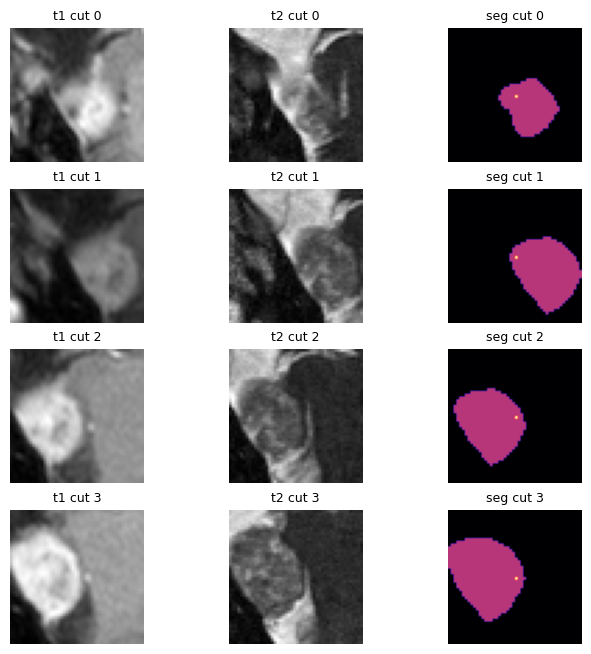

In [67]:
plot_cuts_with_seq([train_cut[0] for train_cut in training_cuts])

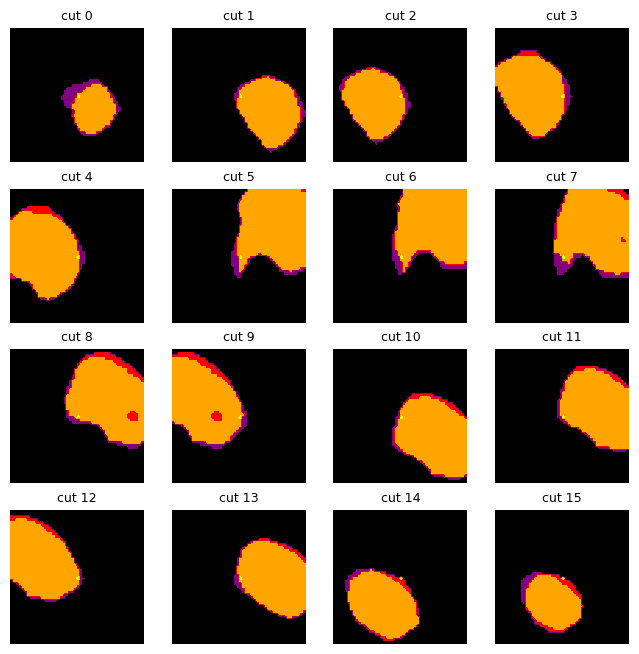

In [68]:
plot_cuts_with_true(
    cuts=[train_cut[0][0] for train_cut in training_cuts],
    true_cuts=[train_cut[1][0] for train_cut in training_cuts],
)

In [69]:
validation_cuts = prepare_cuts(segmentation_model, val_data, cut_size=48)

torch.Size([2, 48, 256, 256]) torch.Size([1, 48, 256, 256])
7 7 7 7
7


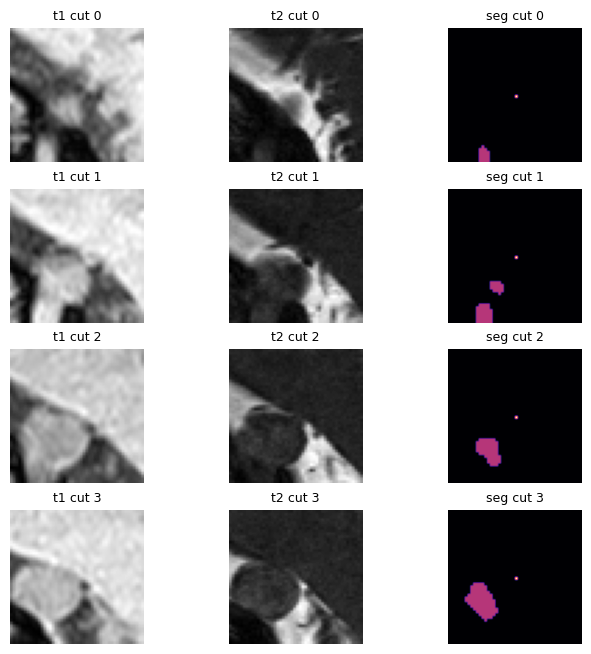

In [72]:
plot_cuts_with_seq([cut[0] for cut in validation_cuts])

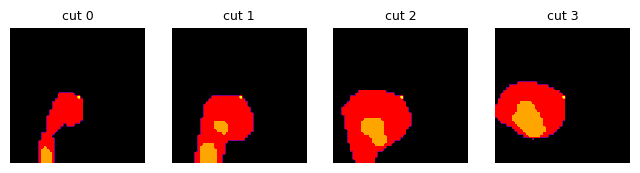

In [73]:
plot_cuts_with_true(
    cuts=[cut[0][0] for cut in validation_cuts],
    true_cuts=[cut[1][0] for cut in validation_cuts],
)

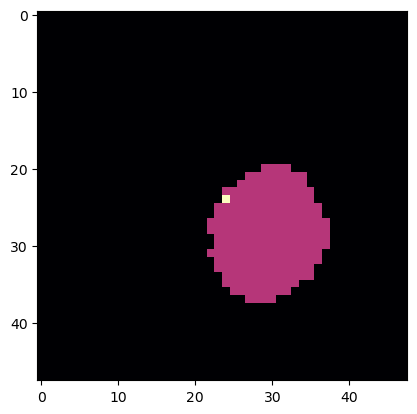

In [108]:
plot_cut(training_cuts[0][1][0])

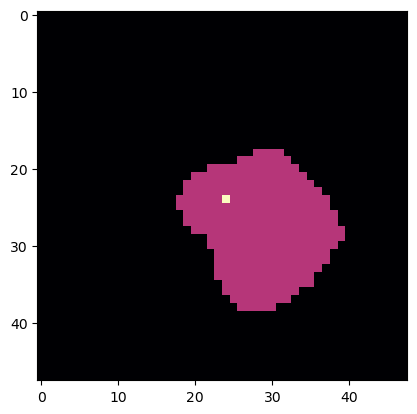

In [107]:
plot_cut(training_cuts[0][0][0])

In [110]:
training_cuts[0][0].unsqueeze(0).shape

torch.Size([1, 3, 48, 48])

In [111]:
a = [training_cuts[0][0], training_cuts[1][0], training_cuts[2][0]]

In [113]:
torch.stack(a, dim=0).shape

torch.Size([3, 3, 48, 48])

In [146]:
def create_batches(data, batch_size):
    batches = []
    x_batch = []
    y_batch = []
    j = 0
    for i, (x, y) in enumerate(data):    
        if i != 0 and i % batch_size == 0:
            batches.append((torch.stack(x_batch, dim=0), torch.stack(y_batch, dim=0)))
            x_batch = []
            y_batch = []

        x_batch.append(x)
        y_batch.append(y)

        if i == len(data) - 1:
            batches.append((torch.stack(x_batch, dim=0), torch.stack(y_batch, dim=0)))
    
    return batches


In [151]:
train_batch = create_batches(training_cuts, batch_size=4)

In [152]:
len(training_cuts)

18

In [153]:
for x, y in train_batch:
    print(x.shape, y.shape)

torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([2, 3, 48, 48]) torch.Size([2, 1, 48, 48])


In [154]:
def plot_batched_cuts(cuts: torch.Tensor, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i in range(cuts.shape[0]):
        if j >= len(axs): 
            break
        tmp_cut = torch.clone(cuts[i,0,:,:])
        tmp_cut[cuts.shape[2]//2, cuts.shape[2]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

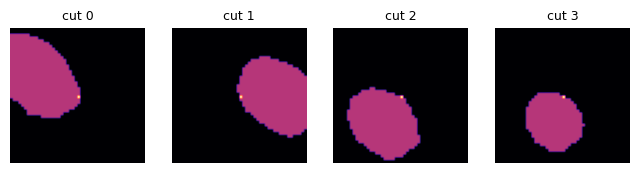

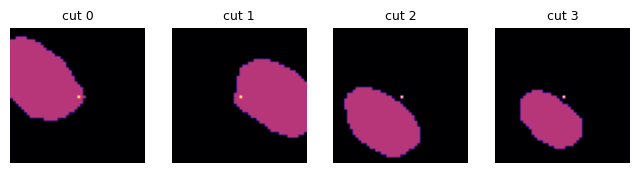

In [169]:
i = 3
plot_batched_cuts(train_batch[i][1])
plot_batched_cuts(train_batch[i][0])

#### Finetunning

In [170]:
from src.model.correction import CorrectionUnet, OGCorrectionUnet, MultiModalCorrectionUnet

In [171]:
# checkpoint = torch.load(os.path.join("../models/correctionloss_allimgs_morechannels_3blocks_attention_seq", "best.pt"), map_location="mps")
# checkpoint = torch.load(os.path.join("../models/multimodal_diceloss_allimgs_morechannels_4blocks_seq", "best.pt"), map_location="mps")
checkpoint = torch.load(os.path.join("../models/multimodal_dice_allimgs_morechannels_dropout_4blocks_seq", "best.pt"), map_location="mps")

# correction_model = OGCorrectionUnet(in_channels=3, out_channels=1, blocks=3).to("mps")
# correction_model = CorrectionUnet(in_channels=3, out_channels=1, blocks=3, use_attention=True, block_channels=[32, 64, 128, 256]).to("mps")
correction_model = MultiModalCorrectionUnet(in_channels=[1, 2], out_channels=1, blocks=3, encoders=2, block_channels=[32, 64, 128, 256], use_dropout=True).to("mps")
correction_model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [172]:
device = 'mps'

In [184]:
avg_loss, avg_dice = 0, 0
for i, (x, y) in enumerate(train_batch):
    print(i, x.shape, y.shape)
    x, y = x.to(device), y.to(device)

    y_pred = correction_model(x)
    
    # loss = loss_fn(y_pred, y)
    dice = dice_coefficient(y_pred, y)
    print(i, dice.item())

    # avg_loss += loss.item()
    avg_dice += dice.item()

avg_dice /= len(train_batch)
print(avg_dice)

0 torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 48, 48])
0 0.9178450107574463
1 torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 48, 48])
1 0.9419084191322327
2 torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 48, 48])
2 0.8464993238449097
3 torch.Size([4, 3, 48, 48]) torch.Size([4, 1, 48, 48])
torch.Size([4, 1, 48, 48]) torch.Size([4, 1, 48, 48])
3 0.9266906976699829
4 torch.Size([2, 3, 48, 48]) torch.Size([2, 1, 48, 48])
torch.Size([2, 1, 48, 48]) torch.Size([2, 1, 48, 48])
4 0.7233642339706421
0.8712615370750427


In [181]:
def preview_cuts_finetunning(pred, x, y, dice):
    rows = pred.shape[0]
    cols = 3
    res = cols if cols > rows else rows
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0

    for i in range(pred.shape[0]):
        tmp_cut = torch.clone(pred[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j].imshow(tmp_cut.cpu().detach(), cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(
            f"correction dice={dice_coefficient(pred[i].unsqueeze(0), y[i].unsqueeze(0)).item():>5f}", 
            fontsize=9,
        )

        tmp_cut = torch.clone(x[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j + 1].imshow(tmp_cut.cpu().detach(), cmap="magma")
        axs[j + 1].axis("off")
        axs[j + 1].set_title("training", fontsize=9)

        tmp_cut = torch.clone(y[i, 0, :, :])
        tmp_cut[pred.shape[2] // 2, pred.shape[2] // 2] = 2
        axs[j + 2].imshow(tmp_cut.cpu().detach(), cmap="magma")
        axs[j + 2].axis("off")
        axs[j + 2].set_title("gt", fontsize=9)

        j += 3
    fig.suptitle(f"Dice: {dice}", fontsize=10)
    plt.subplots_adjust(top=0.9)

0 0.9189047813415527
1 0.936873733997345
2 0.8406686782836914
3 0.9243906736373901
4 0.6841685771942139
0.23916702469189963


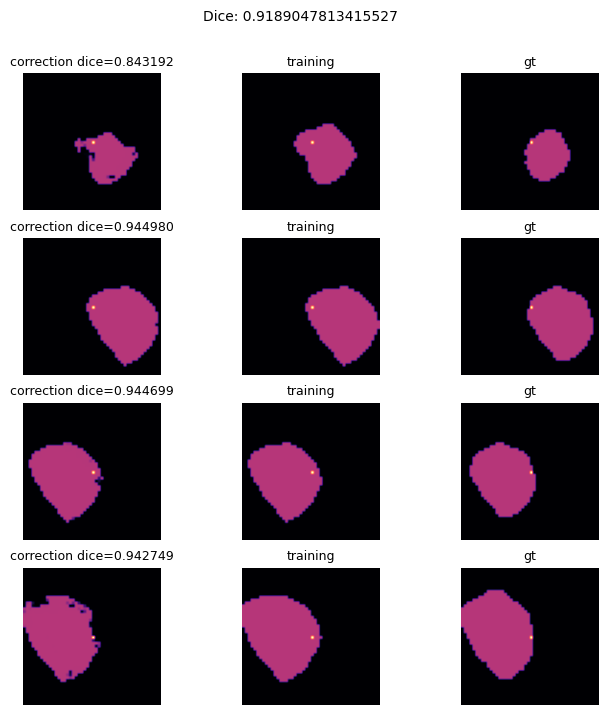

In [183]:
avg_loss, avg_dice = 0, 0
for i, (x, y) in enumerate(train_batch):
    # print(i, x.shape, y.shape)
    x, y = x.to(device), y.to(device)

    y_pred = correction_model(x)
    
    # loss = loss_fn(y_pred, y)
    dice = dice_coefficient(y_pred, y)
    print(i, dice.item())

    # avg_loss += loss.item()
    avg_dice += dice.item()
    if i == 0:
        preview_cuts_finetunning(y_pred, x, y, dice.item())

avg_dice /= len(training_cuts)
print(avg_dice)